# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Purpose of the project
1. Have a good understanding of the datasets
2. Data cleaning and wrangling
3. Study user behavior for messaging, calling and internet data usage
4. Compare the revenue between the two different plans
5. Perform statistical hypothesis tests to check whether the average revenue from users of the Ultimate and Surf plans differs
6. Perform statistical hypothesis tests to check whether the average revenue from users in the NY-NJ area is different from that of the users from the other regions 

## Initialization

In [230]:
# Loading all the libraries

import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mt

## Load data

In [231]:
# Load the data files into different DataFrames
    
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')

## Plans

In [232]:
# Print the general/summary information about the plans' DataFrame

plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [233]:
# Print a sample of data for plans

display(plans.head(5))

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The `plans` dataframe has 2 rows and 8 columns. All columns seem to have the correct values and data types. I do not see any obvious issues with the data. So there is no need to fix anything about it. 

## Users

In [234]:
# Print the general/summary information about the users' DataFrame

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [235]:
# Print a sample of data for users

display(users.head(10))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


In [236]:
users_missing_perct = (users.isna().sum())/users.shape[0]*100
print(users_missing_perct)

user_id        0.0
first_name     0.0
last_name      0.0
age            0.0
city           0.0
reg_date       0.0
plan           0.0
churn_date    93.2
dtype: float64


The `users` dataframe has 500 rows and 8 columns. I think there are three obvious issues with the data set. 
1. The `user_id` column currently has `int64` as the data type. But it makes more sense for `user_id` to be of `string` data type. 
2. The `reg_date` and `churn_date` columns currently have `object` as the data type. But it makes more sense for those two columns to be of `datetime` data type. 
3. The `churn_date` column has 93.2% of its data as missing values. I think customers with missing values for `churn_date` might indicate they are still using the service. 

### Fix Data

I will change the data type of `reg_date` and `churn_date` columns to `datetime` data type. I will also change the data type for `user_id` to be `string`. 

In [237]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['user_id'] = users['user_id'].astype('str')


### Enrich Data

We will create a new column called `active` based on the `churn_date` column. If the `churn_date` = NaN, then `active`  = 1, that means a customer is still actively using the service. If the `churn_date` is not NaN, then `active`  = 0, that means a customer has stopped using the service. 

In [238]:
users['churn_date'].value_counts(dropna=False)

NaT           466
2018-12-18      3
2018-12-19      2
2018-11-14      2
2018-12-31      2
2018-09-01      1
2018-08-19      1
2018-10-03      1
2018-08-16      1
2018-12-15      1
2018-12-12      1
2018-11-11      1
2018-12-26      1
2018-09-07      1
2018-10-22      1
2018-09-18      1
2018-12-10      1
2018-12-27      1
2018-11-30      1
2018-10-13      1
2018-11-24      1
2018-10-07      1
2018-12-22      1
2018-11-21      1
2018-11-18      1
2018-09-17      1
2018-07-31      1
2018-12-30      1
2018-11-29      1
2018-11-16      1
Name: churn_date, dtype: int64

In [239]:
users['active'] = np.where(users['churn_date'].isna(), 1, 0)

In [240]:
users['active'].value_counts(dropna=False)

1    466
0     34
Name: active, dtype: int64

## Calls

In [241]:
# Print the general/summary information about the calls' DataFrame

calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [242]:
# Print a sample of data for calls

display(calls.head(10))

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


In [243]:
calls_missing_perct = (calls.isna().sum())/calls.shape[0]*100
print(calls_missing_perct)

id           0.0
user_id      0.0
call_date    0.0
duration     0.0
dtype: float64


The `calls` dataframe has 137735 rows and 4 columns. No missing values were found! I think there are two obvious issues with the data set. 
1. The `user_id` column currently has `int64` as the data type. But it makes more sense for `user_id` to be of `string` data type. 
2. The `call_date` column currently have `object` as the data type. But it makes more sense for it to be of `datetime` data type. 


### Fix data

We will change the data type of the `user_id` and `call_date` columns to `string` and `datetime`, respectively. 

In [244]:
calls['user_id'] = calls['user_id'].astype('str')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

### Enrich data

Because the analysis is interested in the aggregated data in each month, we will created a new column called `month` that captures the month of the call. 

In [245]:
calls['month'] = calls['call_date'].dt.month

For calls, the length of each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. Thus, we will round the minutes of each call up to the nearest integer.

In [246]:
calls['duration'] = calls['duration'] .apply(np.ceil)

## Messages

In [247]:
# Print the general/summary information about the messages' DataFrame

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [248]:
# Print a sample of data for messages

display(messages.head(10))

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


In [249]:
messages_missing_perct = (messages.isna().sum())/messages.shape[0]*100
display(messages_missing_perct)

id              0.0
user_id         0.0
message_date    0.0
dtype: float64

The `messages` dataframe has 76051 rows and 4 columns. No missing values were found! I think there are two obvious issues with the data set. 
1. The `user_id` column currently has `int64` as the data type. But it makes more sense for `user_id` to be of `string` data type. 
2. The `message_date` column currently have `object` as the data type. But it makes more sense for it to be of `datetime` data type. 


### Fix data

In [250]:
messages['user_id'] = messages['user_id'].astype('str')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

### Enrich data

Because the analysis is interested in the aggregated data in each month, we will created a new column called `month` that captures the month of the messages. 

In [251]:
messages['month'] = messages['message_date'].dt.month

## Internet

In [252]:
# Print the general/summary information about the internet DataFrame

internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [253]:
# Print a sample of data for the internet traffic

display(internet.head(10))

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


In [254]:
internet_missing_perct = (internet.isna().sum())/internet.shape[0]*100
print(internet_missing_perct)

id              0.0
user_id         0.0
session_date    0.0
mb_used         0.0
dtype: float64


The `internet` dataframe has 104825 rows and 4 columns. No missing values were found! I think there are two obvious issues with the data set. 
1. The `user_id` column currently has `int64` as the data type. But it makes more sense for `user_id` to be of `string` data type. 
2. The `session_date` column currently have `object` as the data type. But it makes more sense for it to be of `datetime` data type. 

### Fix data

In [255]:
internet['user_id'] = internet['user_id'].astype('str')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

### Enrich data

Because the analysis is interested in the aggregated data in each month, we will created a new column called `month` that captures the month of the internet sessions. 

In [256]:
internet['month'] = internet['session_date'].dt.month

## Study plan conditions

It is critical to understand how the plans work and how users are charged based on their plan subscription. So let's print out the plan information and view their conditions once again.

In [257]:
# Print out the plan conditions and make sure they are clear for you

display(plans.head(5))

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Aggregate data per user per period

Now, as the data is clean, let's aggregate data per user per period in order to have just one record per user per period. It should ease the further analysis a lot.

In [258]:
calls['call_date'].value_counts(dropna=False)

2018-12-27    1091
2018-12-28    1085
2018-12-30    1080
2018-12-24    1078
2018-12-29    1070
              ... 
2018-01-17       6
2018-01-26       6
2018-01-15       5
2018-01-18       4
2018-01-24       3
Name: call_date, Length: 351, dtype: int64

In [259]:
# Calculate the number of calls made by each user per month. Save the result.

calls_per_user_per_month = calls.pivot_table(index = ['user_id', 'month'], 
                                  values = 'id', 
                                  aggfunc= 'count')

calls_per_user_per_month = calls_per_user_per_month.reset_index()
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html

calls_per_user_per_month.columns = ['user_id', 'month', 'num_calls']
calls_per_user_per_month

,user_id,month,num_calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [260]:
# Calculate the amount of call minutes spent by each user per month. Save the result.

call_minutes_per_user_per_month = calls.pivot_table(index = ['user_id', 'month'], 
                                  values = 'duration', 
                                  aggfunc= 'sum')

call_minutes_per_user_per_month = call_minutes_per_user_per_month.reset_index()

call_minutes_per_user_per_month.columns = ['user_id', 'month', 'call_duration']
call_minutes_per_user_per_month

,user_id,month,call_duration
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2253,1498,12,339.0
2254,1499,9,346.0
2255,1499,10,385.0
2256,1499,11,308.0


In [261]:
# Calculate the number of messages sent by each user per month. Save the result.

messages_per_user_per_month = messages.pivot_table(index = ['user_id', 'month'], 
                                  values = 'id', 
                                  aggfunc= 'count')

messages_per_user_per_month = messages_per_user_per_month.reset_index()
messages_per_user_per_month.columns = ['user_id', 'month', 'num_messages']
messages_per_user_per_month

,user_id,month,num_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

In [262]:
# Calculate the volume of internet traffic used by each user per month. Save the result.

internet_volumn_per_user_per_month = internet.pivot_table(index = ['user_id', 'month'], 
                                  values = 'mb_used', 
                                  aggfunc= 'sum')

internet_volumn_per_user_per_month = internet_volumn_per_user_per_month.reset_index()

internet_volumn_per_user_per_month.columns = ['user_id', 'month', 'gb_used']

internet_volumn_per_user_per_month['gb_used'] = np.ceil(internet_volumn_per_user_per_month['gb_used']/1024)

internet_volumn_per_user_per_month

,user_id,month,gb_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0
...,...,...,...
2272,1498,12,23.0
2273,1499,9,13.0
2274,1499,10,20.0
2275,1499,11,17.0


Let's put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month.

In [263]:
# Merge the data for calls, minutes, messages, internet based on user_id and month

data = calls_per_user_per_month.merge(call_minutes_per_user_per_month, 
                                      left_on=['user_id', 'month'], 
                                      right_on =['user_id', 'month'], 
                                      how='outer')
data = data.merge(messages_per_user_per_month,
                                      left_on=['user_id', 'month'], 
                                      right_on =['user_id', 'month'], 
                                      how='outer')
                                
data = data.merge(internet_volumn_per_user_per_month,
                                      left_on=['user_id', 'month'], 
                                      right_on =['user_id', 'month'], 
                                      how='outer')
data

,user_id,month,num_calls,call_duration,num_messages,gb_used
0,1000,12,16.0,124.0,11.0,2.0
1,1001,8,27.0,182.0,30.0,7.0
2,1001,9,49.0,315.0,44.0,14.0
3,1001,10,65.0,393.0,53.0,22.0
4,1001,11,64.0,426.0,36.0,19.0
...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,13.0
2289,1361,5,NaN,NaN,2.0,2.0
2290,1482,10,NaN,NaN,2.0,NaN
2291,1108,12,NaN,NaN,NaN,1.0


In [264]:
# Add the plan information

data = data.merge(users,
                  left_on=['user_id'], 
                  right_on =['user_id'], 
                  how='left')

data

,user_id,month,num_calls,call_duration,num_messages,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date,active
0,1000,12,16.0,124.0,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,1
1,1001,8,27.0,182.0,30.0,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1
2,1001,9,49.0,315.0,44.0,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1
3,1001,10,65.0,393.0,53.0,22.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1
4,1001,11,64.0,426.0,36.0,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,13.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",2018-10-01,surf,NaT,1
2289,1361,5,NaN,NaN,2.0,2.0,Jacelyn,Hoffman,45,"Birmingham-Hoover, AL MSA",2018-04-14,surf,NaT,1
2290,1482,10,NaN,NaN,2.0,NaN,Armand,Glenn,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-01,ultimate,NaT,1
2291,1108,12,NaN,NaN,NaN,1.0,Porfirio,Kane,45,"Salt Lake City, UT MSA",2018-12-30,ultimate,NaT,1


In [265]:
data = data.drop(['first_name', 'last_name'], axis=1)
data['num_calls'] = data['num_calls'].fillna(0)
data['call_duration'] = data['call_duration'].fillna(0)
data['num_messages'] = data['num_messages'].fillna(0)
data['gb_used'] = data['gb_used'].fillna(0)
data[data['active']==0]

,user_id,month,num_calls,call_duration,num_messages,gb_used,age,city,reg_date,plan,churn_date,active
19,1006,11,2.0,10.0,15.0,3.0,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,0
20,1006,12,9.0,59.0,139.0,32.0,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,0
53,1012,11,10.0,75.0,0.0,14.0,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16,0
54,1012,12,16.0,78.0,0.0,12.0,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16,0
75,1022,5,39.0,302.0,0.0,5.0,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2213,1491,8,54.0,382.0,50.0,11.0,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18,0
2214,1491,9,52.0,414.0,50.0,7.0,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18,0
2215,1491,10,75.0,585.0,51.0,9.0,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18,0
2216,1491,11,46.0,409.0,46.0,6.0,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18,0


Here I have noticed something unusual about the data. Take user with `user_id` 1491 for example, he or she has `churn_date` 2018-09-18, but it shows that he or she still had data usage during `month` 10, 11, 12. If possible, I would like the data provider to provide some explanation about this. 

In [266]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 12 columns):
user_id          2293 non-null object
month            2293 non-null int64
num_calls        2293 non-null float64
call_duration    2293 non-null float64
num_messages     2293 non-null float64
gb_used          2293 non-null float64
age              2293 non-null int64
city             2293 non-null object
reg_date         2293 non-null datetime64[ns]
plan             2293 non-null object
churn_date       158 non-null datetime64[ns]
active           2293 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(3)
memory usage: 232.9+ KB


In [267]:
data['month'].value_counts(dropna=False)

12    469
11    410
10    343
9     280
8     233
7     180
6     144
5     106
4      71
3      35
2      16
1       6
Name: month, dtype: int64

In [268]:
data['plan'].value_counts(dropna=False)

surf        1573
ultimate     720
Name: plan, dtype: int64

Next, we will calculate the monthly revenue from each user.

In [269]:
# Calculate the monthly revenue for each user

surf = {"charge":20, 
       "minutes":500,
       "texts":50,
       "data":15,
       "extra_1minute": 0.03,
       "extra_1message": 0.03,
       "extra_1gb": 10}

ultimate = {"charge":70, 
       "minutes":3000,
       "texts":1000,
       "data":30,
       "extra_1minute": 0.01,
       "extra_1message": 0.01,
       "extra_1gb": 7}

def monthly_revenue_per_user(row):
    
    plan = row['plan'] 
    num_calls = row['num_calls']
    call_duration = row['call_duration']
    num_messages = row['num_messages']
    gb_used = row['gb_used']
    
    
    if plan == 'surf':
        monthly_revenue = surf['charge'] \
            + max((call_duration - surf['minutes'])*surf['extra_1minute'], 0) \
            + max((num_messages - surf['texts'])*surf['extra_1message'], 0)\
            + max((gb_used - surf['data'])*surf['extra_1gb'], 0)
        
        return monthly_revenue
    else:
        monthly_revenue = ultimate['charge'] \
            + max((call_duration - ultimate['minutes'])*ultimate['extra_1minute'], 0) \
            + max((num_messages - ultimate['texts'])*ultimate['extra_1message'], 0)\
            + max((gb_used - ultimate['data'])*ultimate['extra_1gb'], 0)
        
        return monthly_revenue
    
#     for key, value in surf.items():
#         print(key, '->', value)

  
# monthly_revenue_per_user(data.loc[0])
data['revenue'] = data.apply(monthly_revenue_per_user, axis=1)

In [270]:
data

,user_id,month,num_calls,call_duration,num_messages,gb_used,age,city,reg_date,plan,churn_date,active,revenue
0,1000,12,16.0,124.0,11.0,2.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,1,70.00
1,1001,8,27.0,182.0,30.0,7.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1,20.00
2,1001,9,49.0,315.0,44.0,14.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1,20.00
3,1001,10,65.0,393.0,53.0,22.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1,90.09
4,1001,11,64.0,426.0,36.0,19.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,13.0,69,"Boston-Cambridge-Newton, MA-NH MSA",2018-10-01,surf,NaT,1,20.33
2289,1361,5,0.0,0.0,2.0,2.0,45,"Birmingham-Hoover, AL MSA",2018-04-14,surf,NaT,1,20.00
2290,1482,10,0.0,0.0,2.0,0.0,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-01,ultimate,NaT,1,70.00
2291,1108,12,0.0,0.0,0.0,1.0,45,"Salt Lake City, UT MSA",2018-12-30,ultimate,NaT,1,70.00


## Study user behaviour

### Calls

In [271]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.

avg_call_minutes_per_month = data.pivot_table(index = ['plan', 'month'], 
                                             values = 'call_duration', 
                                             aggfunc = 'mean')

avg_call_minutes_per_month = avg_call_minutes_per_month.reset_index()
avg_call_minutes_per_month

,plan,month,call_duration
0,surf,1,203.000000
1,surf,2,297.000000
2,surf,3,330.000000
3,surf,4,351.540000
4,surf,5,399.584416
5,surf,6,431.298969
6,surf,7,449.983471
7,surf,8,410.111111
8,surf,9,414.226804
9,surf,10,429.729958


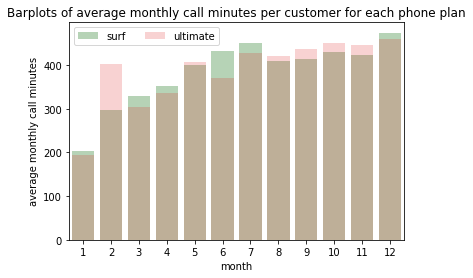

In [272]:
# creating subplots
ax = plt.subplots()
  
# plotting columns
ax = sns.barplot(x=avg_call_minutes_per_month.loc[0:11,'month'], 
                 y=avg_call_minutes_per_month.loc[0:11,'call_duration'], 
                 color='green', alpha=0.3, label='surf')

ax = sns.barplot(x=avg_call_minutes_per_month.loc[12:23,'month'], 
                 y=avg_call_minutes_per_month.loc[12:23,'call_duration'], 
                 color='red', alpha=0.2,label='ultimate')
  
# renaming the axes
ax.set(xlabel="month", 
       ylabel="average monthly call minutes",
       title = 'Barplots of average monthly call minutes per customer for each phone plan')
ax.legend(ncol=2, loc="upper left", frameon=True)

# visulaizing illustration
plt.show()

# https://www.geeksforgeeks.org/how-to-overlap-two-barplots-in-seaborn/
# https://seaborn.pydata.org/examples/part_whole_bars.html

The overlaied barplots of average monthly call minutes per customer for each phone plan show that in Feburary, users with the untimate plan had monthly call minutes around 400 minutes, which is much higher those for the surf plan (300 minutes). In June, users with the surf plan had monthly call minutes around 420 minutes, which is higher those for the untimate plan (around 370 minutes). In any other months, users with both plans had roughly equal number of average monthly call minutes. 

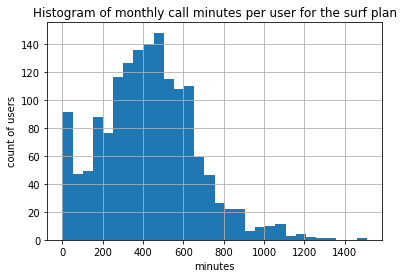

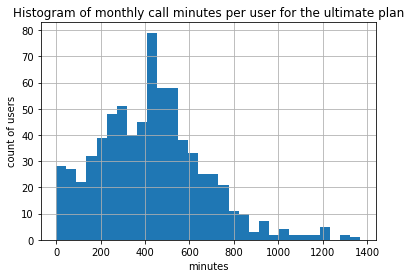

In [273]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.

data_surf = data[data['plan']=='surf']
data_ultimate = data[data['plan']=='ultimate']

data_surf.hist("call_duration", bins=30)
plt.xlabel('minutes')
plt.ylabel('count of users')
plt.title('Histogram of monthly call minutes per user for the surf plan')

data_ultimate.hist("call_duration", bins=30)
plt.xlabel('minutes')
plt.ylabel('count of users')
plt.title('Histogram of monthly call minutes per user for the ultimate plan')

plt.show()

The histograms of monthly call minutes per user for both plan are right-skewed. The shape of both distribution are similar. The majority of the call minutes are between 200 minutes to 600 minutes. Notice that users with surf plan had larger number of counts in general. 

Nest, we will calculate the mean and the variable of the call duration.  

In [274]:
# Calculate the mean and the variance of the monthly call duration

mean_monthly_call_duration_surf = data_surf["call_duration"].mean()
var_monthly_call_duration_surf = np.var(data_surf["call_duration"])
print("The mean monthly call durantion for the surf plan is", round(mean_monthly_call_duration_surf,2))
print("The variance of monthly call durantion for the surf plan is", round(var_monthly_call_duration_surf,2))

mean_monthly_call_duration_ultimate = data_ultimate["call_duration"].mean()
var_monthly_call_duration_ultimate = np.var(data_ultimate["call_duration"])
print("The mean monthly call durantion for the ultimate plan is", round(mean_monthly_call_duration_ultimate,2))
print("The variance of monthly call durantion for the ultimate plan is", round(var_monthly_call_duration_ultimate,2))

The mean monthly call durantion for the surf plan is 428.75
The variance of monthly call durantion for the surf plan is 54933.33
The mean monthly call durantion for the ultimate plan is 430.45
The variance of monthly call durantion for the ultimate plan is 57764.13


We see that the mean and the variable of the call duration for both plans are quite close to each other. So it is very likely that users on the different plans have very similar behaviours for their calls.

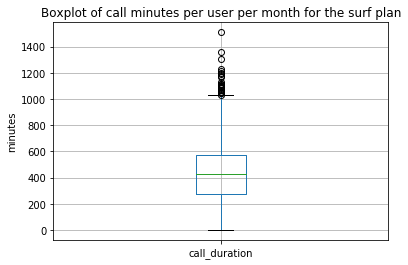

In [275]:
# Plot a boxplot to visualize the distribution of the monthly call duration

data_surf.boxplot("call_duration")
plt.ylabel('minutes')
plt.title('Boxplot of call minutes per user per month for the surf plan')
plt.show()

The Boxplot of call minutes per user per month for the surf plan shows that 75% of its users had call minutes less than 600 per month. Some users called over 1000 minutes per month, which are outliers. Because the free quota for surf plan is 500 monthly minutes, some users were definitely paying extra for phone calls. 

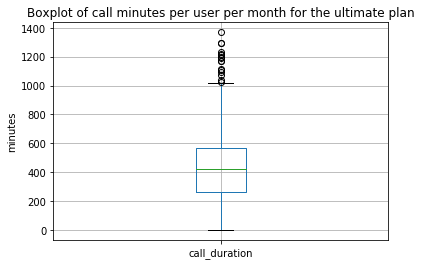

In [276]:

data_ultimate.boxplot("call_duration")
plt.ylabel('minutes')
plt.title('Boxplot of call minutes per user per month for the ultimate plan')
plt.show()

The Boxplot of call minutes per user per month for the ultimate plan shows that 75% of its users had call minutes less than 600 per month. Some users called over 1000 minutes per month, which are outliers. Because the free quota for ultimate plan is 3000 monthly minutes, no users were paying extra for phone calls even though there were outliers. 

In terms of how the users behave in calling, the distribution from both plans are both right-skewed with median around 400 minutes per month and 75% percentile 600 minutes per month. So my conclusion for calling behavior is that users from both plans had similar behaviors.   

### Messages

In [277]:
# Compare the number of messages users of each plan tend to send each month

num_messages_per_month = data.pivot_table(index = ['plan', 'month'], 
                                             values = 'num_messages', 
                                             aggfunc = 'mean')

num_messages_per_month = num_messages_per_month.reset_index()
num_messages_per_month


,plan,month,num_messages
0,surf,1,10.500000
1,surf,2,12.000000
2,surf,3,15.260870
3,surf,4,17.400000
4,surf,5,24.012987
5,surf,6,25.298969
6,surf,7,27.033058
7,surf,8,28.777778
8,surf,9,30.762887
9,surf,10,33.839662


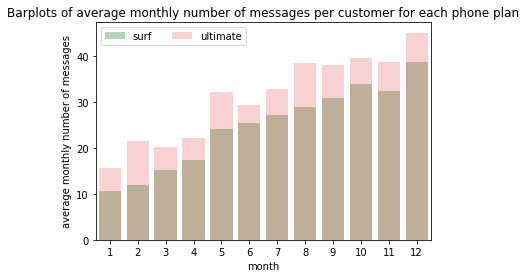

In [278]:
# creating subplots
ax = plt.subplots()
  
# plotting columns
ax = sns.barplot(x=num_messages_per_month.loc[0:11,'month'], 
                 y=num_messages_per_month.loc[0:11,'num_messages'], 
                 color='green', alpha=0.3, label='surf')

ax = sns.barplot(x=num_messages_per_month.loc[12:23,'month'], 
                 y=num_messages_per_month.loc[12:23,'num_messages'], 
                 color='red', alpha=0.2,label='ultimate')
  
# renaming the axes
ax.set(xlabel="month", 
       ylabel="average monthly number of messages",
       title = 'Barplots of average monthly number of messages per customer for each phone plan')
ax.legend(ncol=2, loc="upper left", frameon=True)

# visulaizing illustration
plt.show()

# https://www.geeksforgeeks.org/how-to-overlap-two-barplots-in-seaborn/
# https://seaborn.pydata.org/examples/part_whole_bars.html

We see that across the year, users with the ultimate plan send more messages than those with the surf plan. 

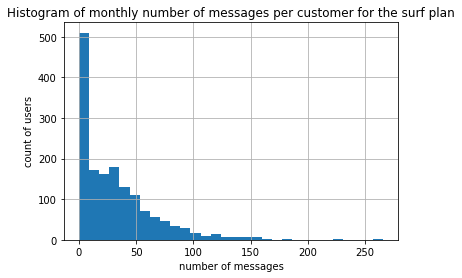

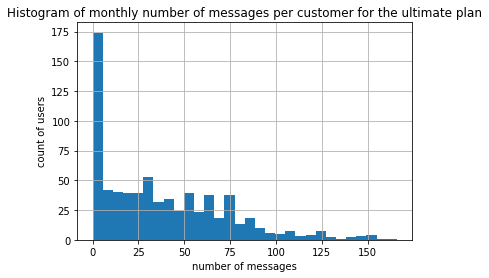

In [279]:

data_surf.hist("num_messages", bins=30)
plt.xlabel('number of messages')
plt.ylabel('count of users')
plt.title('Histogram of monthly number of messages per customer for the surf plan')

data_ultimate.hist("num_messages", bins=30)
plt.xlabel('number of messages')
plt.ylabel('count of users')
plt.title('Histogram of monthly number of messages per customer for the ultimate plan')

plt.show()

The histogram of monthly number of messages per customer for the surf plan shows that it has over 500 users that did not send any messages in some months. The distribution is highly right-skewed. The majority of surf users send less than 100 messages per month. A few users send more than 200 messages a month.  

The histogram of monthly number of messages per customer for the ultimate plan shows that it has over 175 users that did not send any messages in some months. The distribution is highly right-skewed. The majority of ultimate users send less than 100 messages per month. A few users send more than 150 messages a month.  

In [280]:
# Calculate the mean and the variance of the monthly call duration

mean_monthly_num_messages_surf = data_surf["num_messages"].mean()
var_monthly_num_messages_surf = np.var(data_surf["num_messages"])
print("The mean monthly number of messages for the surf plan is", round(mean_monthly_num_messages_surf,2))
print("The variance of monthly number of messages for the surf plan is", round(var_monthly_num_messages_surf,2))

mean_monthly_num_messages_ultimate = data_ultimate["num_messages"].mean()
var_monthly_num_messages_ultimate = np.var(data_ultimate["num_messages"])
print("The mean monthly number of messages for the ultimate plan is", round(mean_monthly_num_messages_ultimate,2))
print("The variance of monthly number of messages for the ultimate plan is", round(var_monthly_num_messages_ultimate,2))


The mean monthly number of messages for the surf plan is 31.16
The variance of monthly number of messages for the surf plan is 1126.01
The mean monthly number of messages for the ultimate plan is 37.55
The variance of monthly number of messages for the ultimate plan is 1207.08


We see that the mean and the variable of monthly number of messages for both plans are quite close to each other. So it is very likely that users on the different plans have very similar messaging behaviours.

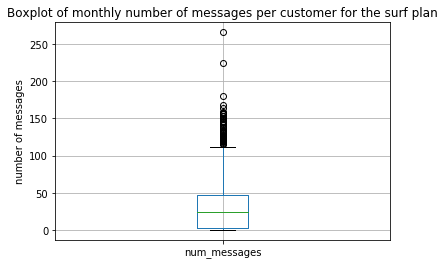

In [281]:
data_surf.boxplot("num_messages")
plt.ylabel('number of messages')
plt.title('Boxplot of monthly number of messages per customer for the surf plan')
plt.show()

The Boxplot of monthly number of messages per customer for the surf plan shows that 75% of its users sent less than 50 messages per month, which is within the free quota of the plan. Some users send over 100 messages, which are outliers. 

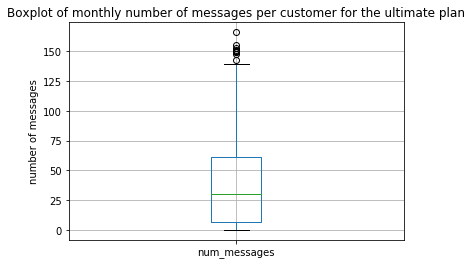

In [282]:
data_ultimate.boxplot("num_messages")
plt.ylabel('number of messages')
plt.title('Boxplot of monthly number of messages per customer for the ultimate plan')
plt.show()

The Boxplot of monthly number of messages per customer for the ultimate plan shows that 75% of its users sent less than 60 messages per month. Some of its users sent over 125 messages or more per month. Those are outliers. But still, it is within the free quota of the plan. 

In terms of how the users behave in messaging, the distribution from both plans are both right-skewed with median around 25 messages per month and 75% percentile around 50 or 60 messages per month. Users from the surf plan has outliers that sent more than 200 messages per month, which was not seen with users from the ultimate plan. So my conclusion for messaging behavior is that users from both plans had similar behaviors.   

### Internet

In [283]:
# Compare the number of messages users of each plan tend to send each month

gb_used_per_month = data.pivot_table(index = ['plan', 'month'], 
                                             values = 'gb_used', 
                                             aggfunc = 'mean')

gb_used_per_month = gb_used_per_month.reset_index()
gb_used_per_month


,plan,month,gb_used
0,surf,1,5.000000
1,surf,2,12.222222
2,surf,3,13.565217
3,surf,4,12.220000
4,surf,5,14.116883
5,surf,6,15.484536
6,surf,7,16.876033
7,surf,8,16.882716
8,surf,9,16.690722
9,surf,10,17.409283


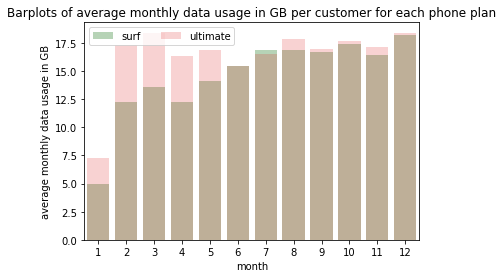

In [284]:
# creating subplots
ax = plt.subplots()
  
# plotting columns
ax = sns.barplot(x=gb_used_per_month.loc[0:11,'month'], 
                 y=gb_used_per_month.loc[0:11,'gb_used'], 
                 color='green', alpha=0.3, label='surf')

ax = sns.barplot(x=gb_used_per_month.loc[12:23,'month'], 
                 y=gb_used_per_month.loc[12:23,'gb_used'], 
                 color='red', alpha=0.2,label='ultimate')
  
# renaming the axes
ax.set(xlabel="month", 
       ylabel="average monthly data usage in GB",
       title = 'Barplots of average monthly data usage in GB per customer for each phone plan')
ax.legend(ncol=2, loc="upper left", frameon=True)

# visulaizing illustration
plt.show()

# https://www.geeksforgeeks.org/how-to-overlap-two-barplots-in-seaborn/
# https://seaborn.pydata.org/examples/part_whole_bars.html

We see that users from both plans had smaller data usage in Janurary compared with the rest of the months. 
Across the year, users with the ultimate plan had more data usage than those with the surf plan. 

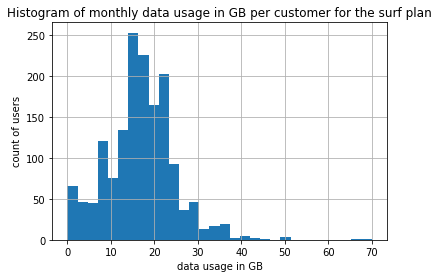

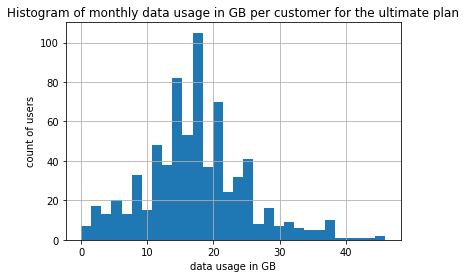

In [285]:

data_surf.hist("gb_used", bins=30)
plt.xlabel('data usage in GB')
plt.ylabel('count of users')
plt.title('Histogram of monthly data usage in GB per customer for the surf plan')

data_ultimate.hist("gb_used", bins=30)
plt.xlabel('data usage in GB')
plt.ylabel('count of users')
plt.title('Histogram of monthly data usage in GB per customer for the ultimate plan')

plt.show()

The histograms of monthly data usage in GB per customer for the surf plan and the ultimate plan are slightly right-skewed. They look similar except that the histogram for the surf plan had more extreme outliers. Both histograms had center around 15 GB.  

In [286]:
# Calculate the mean and the variance of the monthly call duration

mean_monthly_data_usage_surf = data_surf["gb_used"].mean()
var_monthly_data_usage_surf = np.var(data_surf["gb_used"])
print("The mean monthly data usage for the surf plan is", round(mean_monthly_data_usage_surf,2))
print("The variance of monthly data usage for the surf plan is", round(var_monthly_data_usage_surf,2))

mean_monthly_data_usage_ultimate = data_ultimate["gb_used"].mean()
var_monthly_data_usage_ultimate = np.var(data_ultimate["gb_used"])
print("The mean monthly data usage for the ultimate plan is", round(mean_monthly_data_usage_ultimate,2))
print("The variance of monthly data usage for the ultimate plan is", round(var_monthly_data_usage_ultimate,2))


The mean monthly data usage for the surf plan is 16.67
The variance of monthly data usage for the surf plan is 61.54
The mean monthly data usage for the ultimate plan is 17.31
The variance of monthly data usage for the ultimate plan is 58.75


We see that the mean and the variable of monthly data usage for both plans are quite close to each other. So it is very likely that users on the different plans have very similar behaviours in terms of monthly data usage.

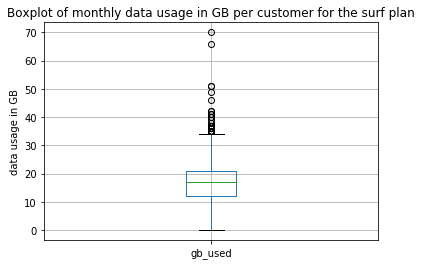

In [287]:
data_surf.boxplot("gb_used")
plt.ylabel('data usage in GB')
plt.title('Boxplot of monthly data usage in GB per customer for the surf plan')
plt.show()

The Boxplot of monthly monthly data usage in GB per customer for the surf plan shows that 75% of its users used less than 21 GB per month. About half of its users used more than 15 GB per month, which exceeded the free monthly quota. 
Some users used more than 50 GB per month! 

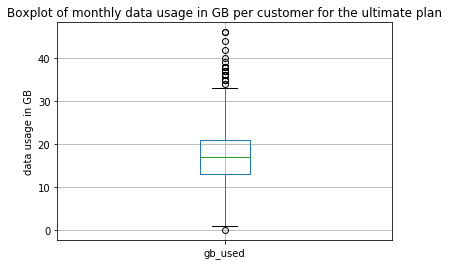

In [288]:
data_ultimate.boxplot("gb_used")
plt.ylabel('data usage in GB')
plt.title('Boxplot of monthly data usage in GB per customer for the ultimate plan')
plt.show()

The Boxplot of monthly monthly data usage in GB per customer for the ultimate plan shows that 75% of its users used less than 21 GB per month. Some users used more than 30 GB per month, which exceeded the free monthly quota.  

In terms of how the users behave in data usage, the distribution from both plans are both right-skewed with median around 17 GB per month and 75% percentile around 21 GB per month. Because the free monthly quota for surf users is 15 GB, half of its users are paying extra for data usage. In contrast, because the free monthly quota for ultimate plan users is 30 GB, not many of its users are paying extra for data usage. So my conclusion for data usage behavior is that users from surf plans tended to exceed the free quota limit of the plan, whereas most of users from the ultimate plan did not exceed the free quota limit of the plan.   

## Revenue

In [289]:
# Compare the number of messages users of each plan tend to send each month

revenue_per_month = data.pivot_table(index = ['plan', 'month'], 
                                             values = 'revenue', 
                                             aggfunc = 'mean')

revenue_per_month = revenue_per_month.reset_index()
revenue_per_month


,plan,month,revenue
0,surf,1,20.000000
1,surf,2,34.396667
2,surf,3,45.941304
3,surf,4,40.710600
4,surf,5,47.628182
5,surf,6,49.276289
6,surf,7,62.674050
7,surf,8,63.931173
8,surf,9,58.271495
9,surf,10,65.421224


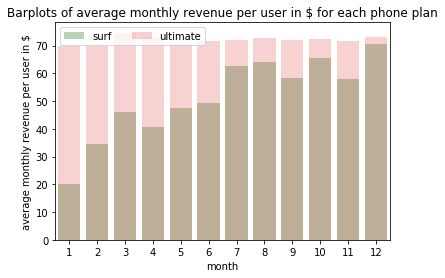

In [290]:
# creating subplots
ax = plt.subplots()
  
# plotting columns
ax = sns.barplot(x=revenue_per_month.loc[0:11,'month'], 
                 y=revenue_per_month.loc[0:11,'revenue'], 
                 color='green', alpha=0.3, label='surf')

ax = sns.barplot(x=revenue_per_month.loc[12:23,'month'], 
                 y=revenue_per_month.loc[12:23,'revenue'], 
                 color='red', alpha=0.2,label='ultimate')
  
# renaming the axes
ax.set(xlabel="month", 
       ylabel="average monthly revenue per user in $",
       title = 'Barplots of average monthly revenue per user in $ for each phone plan')
ax.legend(ncol=2, loc="upper left", frameon=True)

# visulaizing illustration
plt.show()

# https://www.geeksforgeeks.org/how-to-overlap-two-barplots-in-seaborn/
# https://seaborn.pydata.org/examples/part_whole_bars.html

We see that users from the ultimate plan spent around 70 dollars each month across the year. Users from the surf plan spent the least amount of money in Janurary, but their spending kept increasing as time continued. In December, users from the surf plan spent close to 70 dollars each month! 

The monthy package charge is 20 dollars for the surf plan. So many surf users are paying extra for their plan.
The monthy package charge is 70 dollars for the ultimate plan. So few ultimate users are paying extra for their plan.

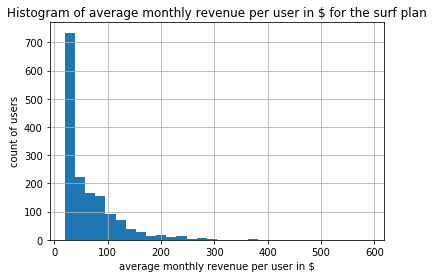

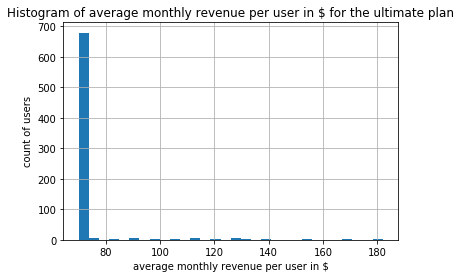

In [291]:

data_surf.hist("revenue", bins=30)
plt.xlabel('average monthly revenue per user in $')
plt.ylabel('count of users')
plt.title('Histogram of average monthly revenue per user in $ for the surf plan')

data_ultimate.hist("revenue", bins=30)
plt.xlabel('average monthly revenue per user in $')
plt.ylabel('count of users')
plt.title('Histogram of average monthly revenue per user in $ for the ultimate plan')

plt.show()

The histograms of average monthly revenue per user in dollar for the surf plan shows that the distribution is highly right-skewed, with the majority of the uses paying less than 100 dollars per month. However, there are some users paying more than 200 dollars a month!

The histograms of average monthly revenue per user in dollar for the ultimate plan shows that the distribution is highly right-skewed, with the majority of the uses paying less than 70 dollars per month. However, there are some users paying somewhere between 80 and 180 dollars a month!
 

In [292]:
# Calculate the mean and the variance of the monthly call duration

mean_monthly_revenue_surf = data_surf["revenue"].mean()
var_monthly_revenue_surf = np.var(data_surf["revenue"])
print("The mean monthly revenue for the surf plan is", round(mean_monthly_revenue_surf,2))
print("The variance of monthly revenue for the surf plan is", round(var_monthly_revenue_surf,2))

mean_monthly_revenue_ultimate = data_ultimate["revenue"].mean()
var_monthly_revenue_ultimate = np.var(data_ultimate["revenue"])
print("The mean monthly revenue for the ultimate plan is", round(mean_monthly_revenue_ultimate,2))
print("The variance of monthly revenue for the ultimate plan is", round(var_monthly_revenue_ultimate,2))


The mean monthly revenue for the surf plan is 60.71
The variance of monthly revenue for the surf plan is 3065.88
The mean monthly revenue for the ultimate plan is 72.31
The variance of monthly revenue for the ultimate plan is 129.67


We see that the mean and the variable of monthly revenue for both plans are quite different from each other. So it is very likely that users on the different plans have very different monthly revenue. 

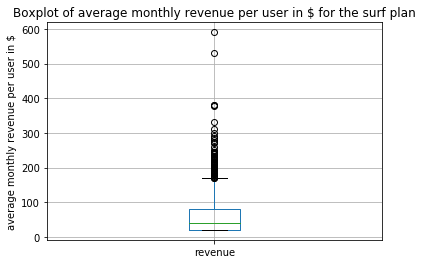

In [293]:
data_surf.boxplot("revenue")
plt.ylabel('average monthly revenue per user in $')
plt.title('Boxplot of average monthly revenue per user in $ for the surf plan')
plt.show()

The Boxplot of average monthly revenue per user in dollar for the surf plan shows that 75% of its paied less than 80 dollars per month. The majority of its users paied more than 20 dollars per month. Some users paying more than 200 dollars a month!

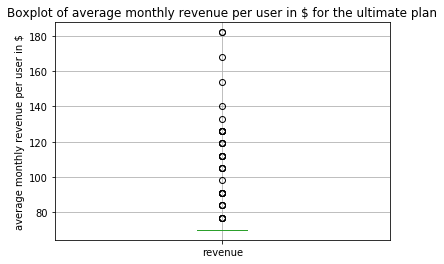

In [294]:
data_ultimate.boxplot("revenue")
plt.ylabel('average monthly revenue per user in $')
plt.title('Boxplot of average monthly revenue per user in $ for the ultimate plan')
plt.show()


The Boxplot of average monthly revenue per user in dollar for the ultimate plan shows most of its paied 70 dollars per month. Some but not many users were paying more than 80 dollars a month!

In terms of how the users behave in monthly cost, the distribution from both plans are quite different. Surf plan users tended to pay more than the 20 dollars plan cost, whereas most of the ultimate plan users did not pay more than 70 dollars. 

## Test statistical hypotheses

Let's test the hypothesis that the average revenue from users of the Ultimate and Surf plans differs. That is, we want to test:
$$ H_0: \mu_{1} =  \mu_{2}$$
$$ H_0: \mu_{1} \ne  \mu_{2}$$
where $\mu_{1}$ is average monthly revenue from users of the surf plan, and $\mu_{2}$ is average monthly revenue from users of the Ultimate plan.

We will use alpha = 0.05 and hypothesis test on the equality of two population means. 

In [295]:
# Test the hypotheses
alpha = 0.05
results = st.ttest_ind(data_surf["revenue"], data_ultimate["revenue"])
print('p-value:', results.pvalue)

p-value: 2.862674510698644e-08


In [296]:
if results.pvalue < alpha:
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.")

We reject the null hypothesis.


Thus, we conclude that the average revenue from users of the Ultimate and Surf plans differs. 

Now let's test the hypothesis that the average revenue from users in the NY-NJ area is different from that of the users from the other regions. That is, we want to test:
$$ H_0: \mu_{1} =  \mu_{2}$$
$$ H_0: \mu_{1} \ne  \mu_{2}$$
where $\mu_{1}$ is average monthly revenue from users in the NY-NJ area, and $\mu_{2}$ is average monthly revenue from users in other regions.

We will use alpha = 0.05 and hypothesis test on the equality of two population means. 

In [297]:
data['city_ny_nj'] = data['city'].str.match(pat=r'.*NY-NJ.*').astype('int')

In [298]:
data

,user_id,month,num_calls,call_duration,num_messages,gb_used,age,city,reg_date,plan,churn_date,active,revenue,city_ny_nj
0,1000,12,16.0,124.0,11.0,2.0,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,1,70.00,0
1,1001,8,27.0,182.0,30.0,7.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1,20.00,0
2,1001,9,49.0,315.0,44.0,14.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1,20.00,0
3,1001,10,65.0,393.0,53.0,22.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1,90.09,0
4,1001,11,64.0,426.0,36.0,19.0,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,1,60.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,13.0,69,"Boston-Cambridge-Newton, MA-NH MSA",2018-10-01,surf,NaT,1,20.33,0
2289,1361,5,0.0,0.0,2.0,2.0,45,"Birmingham-Hoover, AL MSA",2018-04-14,surf,NaT,1,20.00,0
2290,1482,10,0.0,0.0,2.0,0.0,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-01,ultimate,NaT,1,70.00,1
2291,1108,12,0.0,0.0,0.0,1.0,45,"Salt Lake City, UT MSA",2018-12-30,ultimate,NaT,1,70.00,0


In [299]:
# Test the hypotheses
alpha = 0.05

data_city_ny_nj = data[data['city_ny_nj'] ==1]
data_city_other = data[data['city_ny_nj'] ==0]

In [300]:
results = st.ttest_ind(data_city_ny_nj['revenue'], data_city_other['revenue'])
print('p-value:', results.pvalue)

p-value: 0.043557431621342436


In [301]:
if results.pvalue < alpha:
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.")

We reject the null hypothesis.


Thus, we conclude that the average revenue from users in the NY-NJ area is different from that of the users from the other regions. 

## General conclusion

In this project, we analyzed five datasets from the telecom operator Megaline. The major steps for analyzing the data are:

1. Load datasets and perform initial data exploration
2. Fix and enrich data by changing data types and creating new variables when appropriate
3. Merge datasets and study the customer behavior on calling, messaging, using internet and monthly revenue
4. Perform statistical hypothesis tests to check whether the average revenue from users of the Ultimate and Surf plans differs
5. Perform statistical hypothesis tests to check whether the average revenue from users in the NY-NJ area is different from that of the users from the other regions 

The main findings are:
1. Calling behavior of users from both Ultimate and Surf plans are very similar.
2. Messaging behavior of users from both Ultimate and Surf plans are very similar.
3. Data usage behavior of users from both Ultimate and Surf plans are very similar.
4. Monthly revenue of users from both Ultimate and Surf plans are quite different.
5. The average revenue from users of the Ultimate and Surf plans differs.
6. The average revenue from users in the NY-NJ area is different from that of the users from the other regions.


The data shows that many users on the Surf plan are paying extra to get more internet data usage. This might cause customer retaintion issues because many customers are paying more than the plan monthly charge. Thus, we recommend that Megaline come up with a third plan that cost around 50 dollars per month and have more free quota, for example, 25 GB per month for internet usage. This plan will cost less than the current  70 dollars and help retain customers that need more than 15GB but less than 30GB data per month. Moreover, for the Ultimiate plan, 3000 monthly messages and 1000 text messages seem too much for all users, thus, it may be a good idea to lower those numbers in the free quota while at the same time decrease the price of the Ultimiate plan.  